<a href="https://colab.research.google.com/github/the-Soke/FAW-AI-MODEL/blob/main/FAW_AI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SETUP && IMPORTS**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


In [2]:
!unzip /content/dataset-project.zip -d /dataset-project

Archive:  /content/dataset-project.zip
   creating: /dataset-project/dataset/damage/
  inflating: /dataset-project/dataset/damage/0011.jpg  
  inflating: /dataset-project/dataset/damage/0012.jpg  
  inflating: /dataset-project/dataset/damage/0016.jpg  
  inflating: /dataset-project/dataset/damage/0022.jpg  
  inflating: /dataset-project/dataset/damage/0023.jpg  
  inflating: /dataset-project/dataset/damage/0024.jpg  
  inflating: /dataset-project/dataset/damage/0028.jpg  
  inflating: /dataset-project/dataset/damage/0029.jpg  
  inflating: /dataset-project/dataset/damage/0032.jpg  
  inflating: /dataset-project/dataset/damage/0037.jpg  
  inflating: /dataset-project/dataset/damage/0066.jpg  
  inflating: /dataset-project/dataset/damage/0068.jpg  
  inflating: /dataset-project/dataset/damage/0069.jpg  
  inflating: /dataset-project/dataset/damage/0070.jpg  
  inflating: /dataset-project/dataset/damage/0071.jpg  
  inflating: /dataset-project/dataset/damage/0072.jpg  
  inflating: /datas

**LOADING DATASET**

In [3]:
data_dir = '/dataset-project/dataset'
img_size = (180, 180)
batch_size = 32

**SPLITTING THE DATASET**

In [4]:
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
total_batch = tf.data.experimental.cardinality(full_ds).numpy()
train_size = int(0.8 * total_batch)
val_size = int(0.1 * total_batch)

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)
class_names = full_ds.class_names
print("Classes: ", class_names)

# train_ds = image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset='training',
#     seed=123,
#     image_size=img_size,
#     batch_size=batch_size
# )
# val_test_ds = image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset='validation',
#     seed=123,
#     image_size=img_size,
#     batch_size=batch_size
# )
# val_size = int(0.5 * len(val_test_ds))
# val_ds = val_test_ds.take(val_size)
# test_ds = val_test_ds.skip(val_size)

Found 725 files belonging to 3 classes.
Classes:  ['damage', 'floor', 'soil']


**DATA AUGMENTATION**

In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

**NORMALIZE INPUT**

In [6]:
# def normalize_img(image, label):
#     image = tf.cast(image, tf.float32)/255.0
#     return image, label
# train_ds = train_ds.map(normalize_img)
# val_ds = val_ds.map(normalize_img)
# test_ds = test_ds.map(normalize_img)

normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

**OPTIMIZE THE DATA PIPELINE**

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

***BUILD MODEL***

In [8]:

model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_size+(3,)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**COMPILE WITH ADAM OPTIMIZER**

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**CALLBACKS**

In [10]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [11]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.7030 - loss: 0.7022 - val_accuracy: 0.8438 - val_loss: 0.4343 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8599 - loss: 0.4626 - val_accuracy: 0.8438 - val_loss: 0.2750 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9208 - loss: 0.2448 - val_accuracy: 0.9844 - val_loss: 0.0936 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9594 - loss: 0.1584 - val_accuracy: 0.9844 - val_loss: 0.0238 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9702 - loss: 0.0829 - val_accuracy: 1.0000 - val_loss: 0.0113 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9763 - loss: 0.0835 - val_accuracy: 1.0000 - val_loss: 0.0062 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.987

**EVALUATE ON TEST SET**

In [13]:
print("\nEvaluate on test set:")
# Collect true labels and predictions separately
y_true_test = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs_test = model.predict(test_ds)
y_pred_test = np.argmax(y_pred_probs_test, axis=-1)

# Evaluate the model using the collected data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")



Evaluate on test set:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.7654e-05
Test loss: 0.0000
Test accuracy: 1.0000


**CLASSIFICATION REPORT**

In [14]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=-1)
print(f"\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Detailed Classification Report:
              precision    recall  f1-score   support

      damage       1.00      1.00      1.00         4
       floor       1.00      1.00      1.00        15
        soil       1.00      1.00      1.00        66

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



**CONFUSION MATRIX**

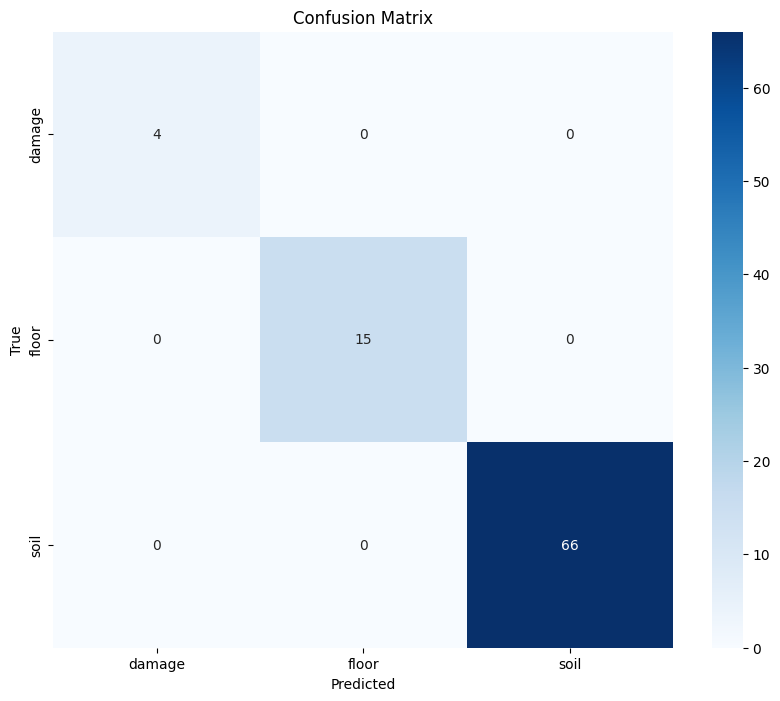

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**PLOT ACCURACY && LOSS**

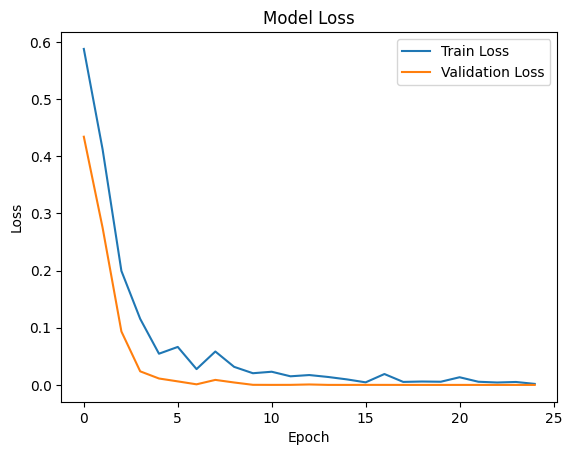

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

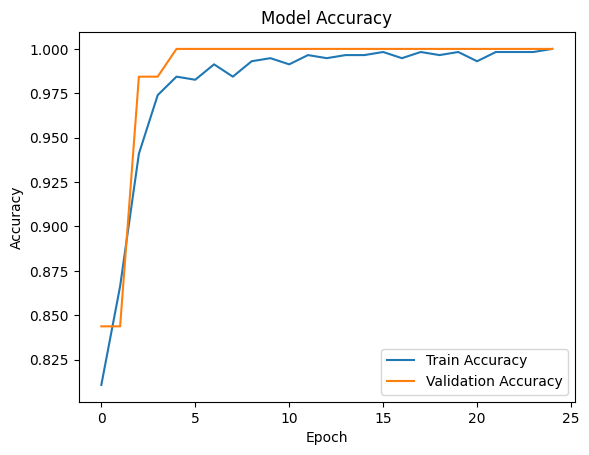

In [17]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [18]:
model.save('faw-model-pipeline.keras')